In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import arviz as az
import sys

In [2]:
# load file with plotting stlye definitions
sys.path.append('../')
plt.style.use('plotting_style.mpltstyle')

# Model Comparison
This notebook shows inferred parameter distributions of all models and performs model comparison based on LOO from the ArviZ package.

### Load Posteriors

In [3]:
def load_posteriors(path, filename):
    filename = f'{path}/{filename}'
    with open(filename, 'rb') as f:
        posterior = pd.read_pickle(f)

    return posterior

In [4]:
# load posteriors -> SELECT RIGHT PATH DEPENDING ON OS!
#path = '/Volumes/T7/Pacman_Pickle/' # iOS
path = 'E:Pacman_Pickle/' # Windows

In [5]:
posteriorsEVM = load_posteriors(path, 'posterior_EVM_empirical.pkl') 
posteriorsEVPM = load_posteriors(path, 'posterior_EVPM_empirical.pkl')
posteriorsEVPBM = load_posteriors(path, 'posterior_EVPBM_empirical.pkl')
posteriorsEVPRM = load_posteriors(path, 'posterior_EVPRM_empirical.pkl')

## Calculate LOOs

In [6]:
# deviance scale (for LOO model comparison)
loosEVM = az.loo(posteriorsEVM, scale='deviance', pointwise=True)
loosEVPM = az.loo(posteriorsEVPM, scale='deviance', pointwise=True)
loosEVPBM = az.loo(posteriorsEVPBM, scale='deviance', pointwise=True)
loosEVPRM = az.loo(posteriorsEVPRM, scale='deviance', pointwise=True)

c:\Users\s3090986\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\s3090986\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\s3090986\Ap

In [7]:
# save the LOOs
f = open('../data_empirical/LOOs.pkl', 'wb')
pickle.dump((loosEVM, loosEVPM, loosEVPBM, loosEVPRM), f)
f.close()

## Model Comparison Group-Level

In [8]:
# load LOOs
f = open('../data_empirical/LOOs.pkl', 'rb')
loosEVM, loosEVPM, loosEVPBM, loosEVPRM = pd.read_pickle(f)
f.close()

In [9]:
# create df with LOOs (incl. SE)
dfModelComparison = pd.DataFrame(index=['EVM', 'EVPM', 'EVPBM', 'EVPRM'])
dfModelComparison['LOOIC'] = np.array([loosEVM.elpd_loo, loosEVPM.elpd_loo, loosEVPBM.elpd_loo, loosEVPRM.elpd_loo])
dfModelComparison['SE'] = np.array([loosEVM.se, loosEVPM.se, loosEVPBM.se, loosEVPRM.se])

# add LOOIC difference of all models compared to winning EVPRM model for nicer plotting
dfModelComparison['delta_LOOIC'] = np.abs(dfModelComparison['LOOIC']-dfModelComparison.iloc[3,0])

In [10]:
dfModelComparison

,LOOIC,SE,delta_LOOIC
EVM,162308.575947,1355.019012,92365.758752
EVPM,74301.956584,1018.948130,4359.139389
EVPBM,73285.863946,983.731043,3343.046752
EVPRM,69942.817195,825.938841,0.000000


### Model Comparison (McElreath Approach)

This approach was suggested by McElreath in Statistical Rethinking (Chapter 7.5) and based on the SE of the LOO differences. ArviZ uses this approach for <code>az.compare</code>.

(see https://learning.oreilly.com/library/view/statistical-rethinking-2nd/9780429639142/xhtml/15_Chapter07.xhtml#sec7_5)

In [12]:
compareDict = {'EVPM':posteriorsEVPM, 'EVPBM':posteriorsEVPBM, 'EVPRM':posteriorsEVPRM, 'EVM':posteriorsEVM}
modelComparison = az.compare(compareDict, scale='deviance')

c:\Users\s3090986\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\s3090986\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\s3090986\Ap

In [13]:
modelComparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
EVPRM,0,69942.817195,810.924480,0.000000,0.655522,825.938841,0.000000,True,deviance
EVPBM,1,73285.863946,1054.579899,3343.046752,0.000000,983.731043,382.346319,True,deviance
EVPM,2,74301.956584,772.521729,4359.139389,0.329069,1018.948130,421.925339,True,deviance
EVM,3,162308.575947,371.924369,92365.758752,0.015409,1355.019012,1319.666900,False,deviance


In [14]:
# dLOOIC +/-1 *dSE*2.6 (2.6 -> 99% interval: z-score of about 2.6)
modelComparison['elpd_diff'][1]+modelComparison['dse'][1]*2.6

C:\Users\s3090986\AppData\Local\Temp\ipykernel_7596\66548456.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  modelComparison['elpd_diff'][1]+modelComparison['dse'][1]*2.6


4337.1471817322235

In [15]:
modelComparison['elpd_diff'][1]-modelComparison['dse'][1]*2.6

C:\Users\s3090986\AppData\Local\Temp\ipykernel_7596\4029744071.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  modelComparison['elpd_diff'][1]-modelComparison['dse'][1]*2.6


2348.946321410281

In [16]:
# save (pickle) model comparison result
f = open('../data_empirical/model_comparison.pkl', 'wb')
pickle.dump(modelComparison, f)
f.close()

## Model Comparison Participant-Level

In [7]:
#f = open('../data_empirical/LOOs.pkl', 'rb')
#loosEVM, loosEVPM, loosEVPBM, loosEVPRM = pickle.load(f)
#f.close()

In [18]:
# load empirical data (to know the trial IDs of time out trials)
dfData = pd.read_csv('../data_empirical/data_cleaned.csv', header=0, usecols=['Participant_ID', 'time_out', 'sequence_ID']) 

# get the participant Idxs of the non time out trials
nonTimeOutIdxs = dfData.loc[dfData['time_out']==0, 'Participant_ID'].to_numpy()

In [19]:
# create df with individual LOOs
# model.loo_i: trial-wise LOOs, excluding time-out trials
dfLOO = pd.DataFrame()

dfLOO['Participant_ID'] = nonTimeOutIdxs
dfLOO['EVM'] = loosEVM.loo_i.to_numpy().flatten()
dfLOO['EVPM'] = loosEVPM.loo_i.to_numpy().flatten()
dfLOO['EVPBM'] = loosEVPBM.loo_i.to_numpy().flatten()
dfLOO['EVPRM'] = loosEVPRM.loo_i.to_numpy().flatten()

# calculate sums
dfLOO = dfLOO.groupby('Participant_ID').sum() #.reset_index()

# add column with best model fit
bestModelParticipant = dfLOO.idxmin(axis=1)
dfLOO['best_fit'] = bestModelParticipant

In [21]:
f = open('../data_empirical/results_model_comparison.pkl', 'wb')
pickle.dump(dfLOO, f)
f.close()

#### best fit overview

In [22]:
dfLOO['best_fit'].value_counts()

best_fit
EVPM     28
EVPRM    27
EVPBM    15
Name: count, dtype: int64

#### calculate LOO differences for each participant grouped by best fit for plotting

In [23]:
dfLOO.sort_values('best_fit', inplace=True)
dfLOO['participant_ID'] = np.arange(len(dfLOO))

In [24]:
dfLoosMelted = dfLOO.melt(id_vars=['participant_ID', 'best_fit'], 
                            value_vars=['EVPM', 'EVPRM', 'EVPBM'], 
                            var_name='model', value_name='LOO')

<Figure size 1000x600 with 0 Axes>

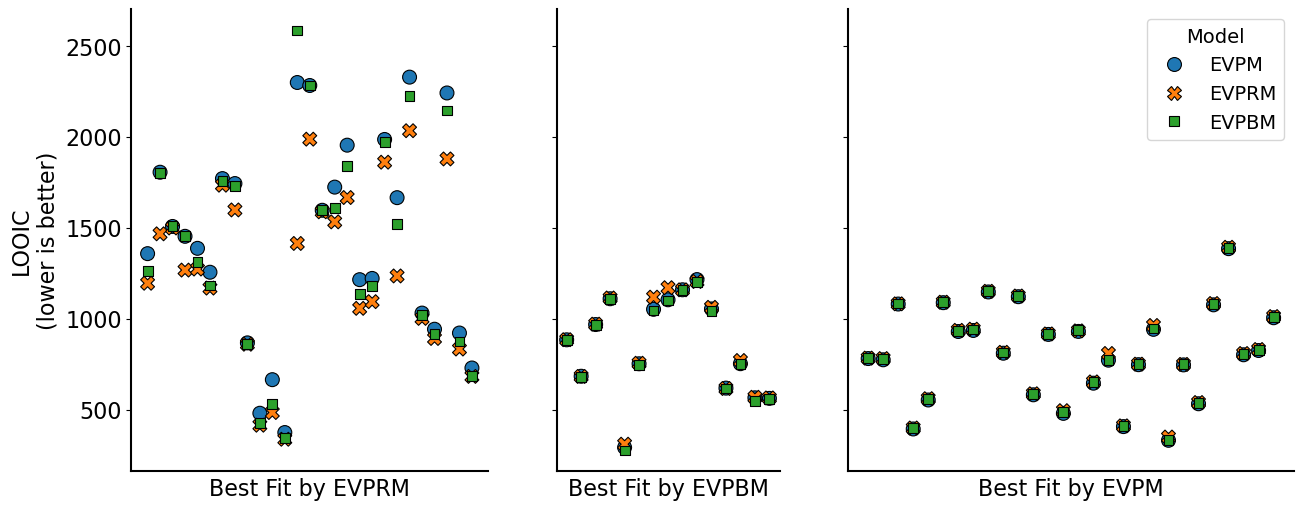

In [26]:
plt.figure()
fig, axBottom = plt.subplots(1,3, figsize=(15,6), width_ratios=[.8,.5,1], sharey=True)

# 1) best fit EVPRM
dfPlot = dfLoosMelted.loc[dfLoosMelted['best_fit']=='EVPRM']
sns.scatterplot(data=dfPlot, x='participant_ID', y='LOO', hue='model', style='model', edgecolor='black', s=100, ax=axBottom[0])
axBottom[0].set_ylabel('LOOIC\n(lower is better)', fontsize=16)
axBottom[0].set_xlabel('Best Fit by EVPRM', fontsize=16)
axBottom[0].set_xticks([])
axBottom[0].get_legend().remove()
# axBottom[0].text(31, 2700, 'C', fontsize=20, weight='bold')

# 2) best fit EVPBM
dfPlot = dfLoosMelted.loc[dfLoosMelted['best_fit']=='EVPBM']
sns.scatterplot(data=dfPlot, x='participant_ID', y='LOO', style='model', s=100, hue='model', edgecolor='black', ax=axBottom[1])
axBottom[1].set_ylabel('')
axBottom[1].set_xlabel('Best Fit by EVPBM', fontsize=16)
axBottom[1].set_xticks([])
axBottom[1].get_legend().remove()

# 3) best fit EVPM
dfPlot = dfLoosMelted.loc[dfLoosMelted['best_fit']=='EVPM']
sns.scatterplot(data=dfPlot, x='participant_ID', y='LOO', style=dfPlot['model'], hue=dfPlot['model'], s=100, edgecolor='black', ax=axBottom[2]) #.map(legendMap)
axBottom[2].set_ylabel('')
axBottom[2].set_xlabel('Best Fit by EVPM', fontsize=16)
axBottom[2].set_xticks([])
axBottom[2].legend(title='Model', fontsize=14, title_fontsize=14)

plt.savefig('model_comparison.svg', format='svg')

sns.despine()
plt.show()

# Create table with fitted parameters

In [27]:
def add_inferred_parameters(df, posterior, modelName, parameters):
    # loop over parameters
    for p in parameters:
        parameterValues = az.summary(posterior, var_names=[p]) # calculate means and SDs

        # add both to existing df
        df[f'{modelName}_{p}_mean'] = parameterValues['mean'].to_numpy()
        df[f'{modelName}_{p}_sd'] = parameterValues['sd'].to_numpy()
    
    return df

In [28]:
dfInference = pd.DataFrame()
dfInference = add_inferred_parameters(dfInference, posteriorsEVM, 'EVM', ['beta'])
dfInference = add_inferred_parameters(dfInference, posteriorsEVPM, 'EVPM', ['beta', 'R0'])
dfInference = add_inferred_parameters(dfInference, posteriorsEVPBM, 'EVPBM', ['beta', 'R0', 'bias'])
dfInference = add_inferred_parameters(dfInference, posteriorsEVPRM, 'EVPRM', ['beta', 'R0', 'h'])

In [29]:
# add best fitting model and p(DAS)
dfInference['best_fit'] = bestModelParticipant

In [30]:
IdxDAS = 4
dfData['DAS'] = np.where(dfData['sequence_ID']==IdxDAS, 1, 0)
dfInference['p(DAS)'] = dfData['DAS'].groupby(dfData['Participant_ID']).mean()

In [31]:
dfInference.to_pickle('../data_empirical/inferred_parameters.pkl')

### Look at EVPRM parameter distributions depending on best fit

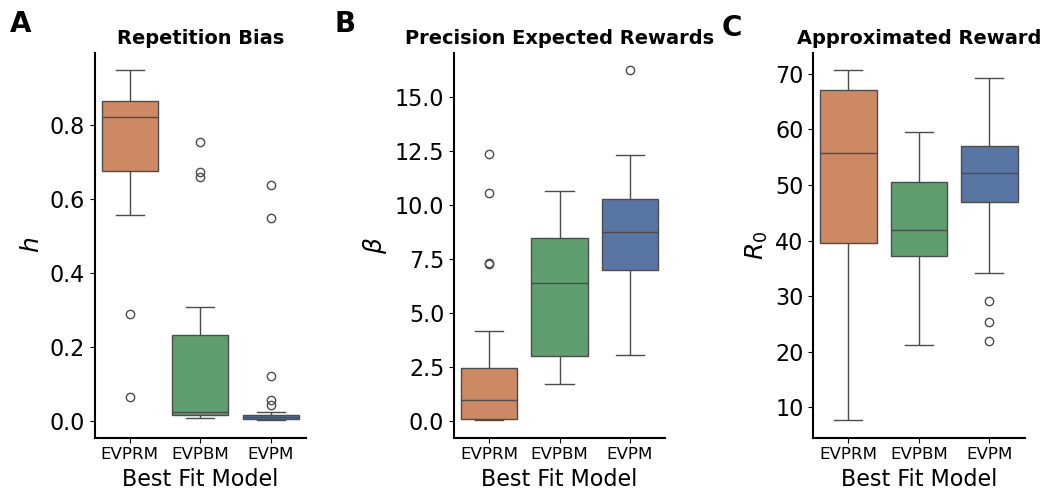

In [36]:
fig, axs = plt.subplots(1,3, figsize=(12,5), gridspec_kw={'wspace':.7})

colorMap = sns.color_palette("deep")
colors = [colorMap[1], colorMap[2], colorMap[0]]

# repetition bias h
sns.boxplot(data=dfInference.sort_values('EVPRM_h_mean', ascending=False), 
            x='best_fit', 
            y='EVPRM_h_mean', 
            hue='best_fit', 
            palette=colors,
            legend=False, 
            ax=axs[0])
axs[0].set_title(r'Repetition Bias', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Best Fit Model', fontsize=16)
axs[0].set_ylabel(r'$h$', fontsize=18)
axs[0].text(-1.7, 1.05, 'A', fontsize=20, weight='bold')

# precision on expected rewards beta
sns.boxplot(data=dfInference.sort_values('EVPRM_h_mean', ascending=False), 
            x='best_fit', 
            y='EVPRM_beta_mean', 
            hue='best_fit', 
            palette=colors,
            legend=False,
            ax=axs[1])
axs[1].set_title(r'Precision Expected Rewards', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Best Fit Model', fontsize=16)
axs[1].set_ylabel(r'$\beta$', fontsize=18)
axs[1].text(-2.2, 18, 'B', fontsize=20, weight='bold')

# approximated reward R0
sns.boxplot(data=dfInference.sort_values('EVPRM_h_mean', ascending=False), 
            x='best_fit', 
            y='EVPRM_R0_mean', 
            hue='best_fit', 
            palette=colors, 
            legend=False, 
            ax=axs[2])
axs[2].set_title(r'Approximated Reward', fontsize=14, fontweight='bold')
axs[2].set_xlabel('Best Fit Model', fontsize=16)
axs[2].set_ylabel(r'$R_0$', fontsize=18)
axs[2].text(-1.8, 76.8, 'C', fontsize=20, weight='bold')

for ax in [axs[0], axs[1], axs[2]]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=16)

sns.despine()
#plt.tight_layout()
plt.show()

In [37]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu May 02 2024

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

matplotlib: 3.8.0
arviz     : 0.16.1
seaborn   : 0.13.0
pandas    : 2.1.1
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:29:11) [MSC v.1935 64 bit (AMD64)]
numpy     : 1.25.2

Watermark: 2.4.3

